# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from PIL import Image

# Libraries for showing random samples
from numpy import random
import matplotlib
import matplotlib.pyplot as plt

import keras
from keras import layers



# Import Data
IN this section, the following tasks are done


1.   Importing the MNIST handwritten digit dataset from tensorflow.keras.datasets and unpack the x train/test set and the y train/test set([Ref](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data?_gl=1*rt9ejc*_up*MQ..*_ga*NDI3MTg5MDAwLjE3MzAyNTM3NzQ.*_ga_W0YLR4190T*MTczMDI1Mzc3NC4xLjAuMTczMDI1Mzc3NC4wLjAuMA..))
2.   Investigate the size of the train and test sets, including the features and the label in each set
3.   Normalize the data to a range of [0,1] for better training convergence.
4.   Visualize the input of the dataset by displaying 25 random samples



In [45]:
# Load the MNIST dataset
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()

# Showing the dimension of the 4 sets
print(f"Dimension of the x_train set: {x_train_raw.shape} \n"
      f"Dimension of the y_train set: {y_train_raw.shape} \n"
      f"Dimension of the x_test set: {x_test_raw.shape} \n"
      f"Dimension of the y_test set: {y_test_raw.shape}")

# Normalize the input pixels from a range of [0,255] to [0,1]
x_train = x_train_raw/-255
x_test = x_test_raw/-255

input_shape = (28,28,1)
output_classes = 10

Dimension of the x_train set: (60000, 28, 28) 
Dimension of the y_train set: (60000,) 
Dimension of the x_test set: (10000, 28, 28) 
Dimension of the y_test set: (10000,)


By running the code block above, it can be seen that

*  60,000 samples in the dataset are used in training.
*  10,000 samples are usedfor testing (approx 85/15 split)
*  The input map has the size of 28x28



In the code block below, we can inspect the label column of the dataset to see how the desired labels are given.

In [4]:
y_train_raw

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

When run, the block returns an array of the training labels as the single integer output for each instances. However, I will later train a network to output a probability distribution of 10 different classes, each representing the digit from 0 to 9.

Therefore, I must use one-hot encoding to convert these single integer labels into $1\times10$ vectors. The code block below performs this operation and display the dimension of the training and testing labels

In [46]:
# One hot encode the label
y_train = to_categorical(y_train_raw, num_classes=output_classes)
y_test = to_categorical(y_test_raw,num_classes=output_classes)

print(f"Dimension of the y_train set: {y_train.shape} \n"
      f"Dimension of the y_test set: {y_test.shape}")

Dimension of the y_train set: (60000, 10) 
Dimension of the y_test set: (10000, 10)


The code block below is used for visualizing random handwritten digit samples in the dataset

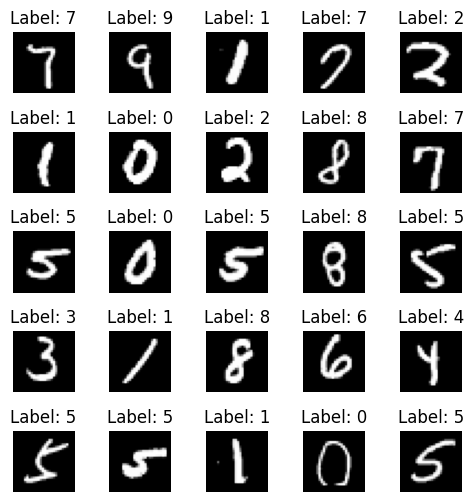

In [47]:
num_samples = 25
rand = random.randint(60000,size = (num_samples))
x_samples = x_train[rand,:,:]
y_samples = np.argmax(y_train[rand,:],axis=1)

fig, axes = plt.subplots(5,5,figsize=(5,5))

for i in range(5):
  for j in range(5):
    ax = axes[i,j]
    ax.imshow(x_samples[i*5+j,:,:], cmap=matplotlib.cm.Greys)
    ax.axis("off")
    ax.set_title(f"Label: {y_samples[i*5+j]}")

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust top to make room for title
plt.show()


# Helper Functions

In [48]:
def plot_performance(history, learning_rate=None, batch_size=None):
  fig1, axes1 = plt.subplots(1,2,figsize = (10,5))

  # Accuracy of model training and validation vs training epoch
  acc_ax = axes1[0]
  acc_ax.plot(history.history['accuracy'])
  acc_ax.plot(history.history['val_accuracy'])

  if learning_rate and batch_size:
    acc_ax.set_title(f'Model accuracy \n lr = {learning_rate}, batch size = {batch_size}')
  else: acc_ax.set_title('Model accuracy')

  acc_ax.set_ylabel('Accuracy')
  acc_ax.set_xlabel('Epoch')
  acc_ax.legend(['Training', 'Validation'], loc='best')

  # Loss during model training and validation
  loss_ax = axes1[1]
  loss_ax.plot(history.history['loss'])
  loss_ax.plot(history.history['val_loss'])
  if learning_rate and batch_size:
    loss_ax.set_title(f'Model loss \n lr = {learning_rate}, batch size = {batch_size}')
  else: loss_ax.set_title('Model loss')
  loss_ax.set_ylabel('Loss')
  loss_ax.set_xlabel('Epoch')
  loss_ax.legend(['Training', 'Validation'], loc='best')
  plt.show()

  print(f"The model has a training accuracy of {history.history['accuracy'][-1]*100:.2f}%\n"
      f"The model has a validation accuracy of {history.history['val_accuracy'][-1]*100:.2f}%")
  return

# Construct the model

In this section, I shall build a simple 2D CNN borrowing the LeNet architecture, which was originally used for this dataset. This simplified network includes


*   2 convolutional layers, each followed by a max pooling layer
*   1 fully connected layer to output the final classification



In [7]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(output_classes, activation="softmax"),
])

intial_weights = model.get_weights()

model.summary()

c:\mnguyen\TME_6015\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

# Model Compilation and Training

In [8]:
batch_size = 128    # The number of samples seen before the model update the weights
epochs = 15         # Number of training episodes
lr = 0.0001          # Learning rate for the optimizer

optimizer1 = keras.optimizers.Adam(
    learning_rate = lr
)

model.compile(loss="categorical_crossentropy",
              optimizer=optimizer1,
              metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5457 - loss: 1.7723 - val_accuracy: 0.8956 - val_loss: 0.3956
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8963 - loss: 0.3687 - val_accuracy: 0.9342 - val_loss: 0.2436
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9302 - loss: 0.2464 - val_accuracy: 0.9477 - val_loss: 0.1889
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9444 - loss: 0.1910 - val_accuracy: 0.9577 - val_loss: 0.1570
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9548 - loss: 0.1600 - val_accuracy: 0.9629 - val_loss: 0.1400
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9600 - loss: 0.1374 - val_accuracy: 0.9669 - val_loss: 0.1224
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9643 - loss: 0.1215 - val_accuracy: 0.9701 - val_loss: 0.1116
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9681 - loss: 0.1112 - val_accuracy: 0.

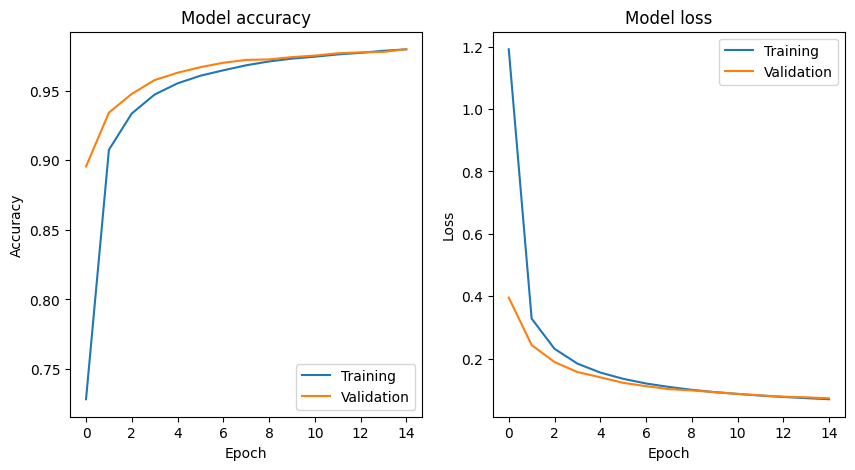

The model has a training accuracy of 97.97%
The model has a validation accuracy of 97.98%


In [9]:
plot_performance(history)

# Model Retraining

In this section, I am increasing the number of epochs to 150 so that the model can continue learning until it starts to overfit (validation loss starts increasing)

In [23]:
batch_size = 128    # The number of samples seen before the model update the weights
epochs = 150        # Number of training episodes
lr = 0.0001         # Learning rate for the optimizer


optimizer = keras.optimizers.Adam(
    learning_rate = lr
)
model.set_weights(intial_weights)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer1,
              metrics=["accuracy"])

history_1 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/150
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4995 - loss: 1.6919 - val_accuracy: 0.8936 - val_loss: 0.3817
Epoch 2/150
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8911 - loss: 0.3787 - val_accuracy: 0.9271 - val_loss: 0.2614
Epoch 3/150
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9205 - loss: 0.2659 - val_accuracy: 0.9406 - val_loss: 0.2139
Epoch 4/150
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9364 - loss: 0.2186 - val_accuracy: 0.9527 - val_loss: 0.1726
Epoch 5/150
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9478 - loss: 0.1784 - val_accuracy: 0.9596 - val_loss: 0.1501
Epoch 6/150
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9545 - loss: 0.1573 - val_accuracy: 0.9642 - val_loss: 0.1303
Epoch 7/150
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9617 - loss: 0.1321 - val_accuracy: 0.9674 - val_loss: 0.1175
Epoch 8/150
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9666 - loss: 0.1164 - val_accu

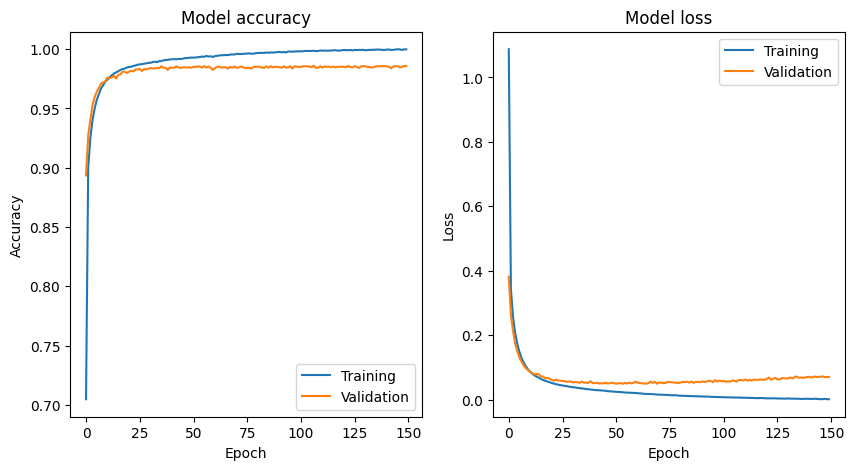

The model has a training accuracy of 99.98%
The model has a validation accuracy of 98.58%


In [24]:
plot_performance(history_1)

One can see that the model has started to overfit around 50 epochs. This number is fixed moving forward for the hyperparameter experiment

# Model Hyperparameter Experiment

## Learning Rate Experiment
In the code block below, the learning rate are varied between [0.001, 0.0005, and 0.0001] to evaluate the model training. The number of epochs is fixed at 50 and the batch  size at 128

In [ ]:
history_all = []

batch_size = 128
epochs = 50
lr = [0.001, 0.0005, 0.0001]

for i in range(len(lr)):
    # Reset the weights of the model to start training from the same initial weights
    model.set_weights(intial_weights)

    # Adjust the optimizer with the corresponding learning rate
    optimizer = keras.optimizers.Adam(learning_rate = lr[i])

    model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

    print(f"=== Model training with lr = {lr[i]}, batch size = {batch_size} ===")
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

    # Append a dictionary of the training parameters and training history
    history_all.append({
        'learning_rate': lr[i],
        'batch_size': batch_size,
        'history': history
    })

=== Model training with lr = 0.001, batch size = 128 ===
Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8159 - loss: 0.6382 - val_accuracy: 0.9793 - val_loss: 0.0750
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9733 - loss: 0.0846 - val_accuracy: 0.9840 - val_loss: 0.0577
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9808 - loss: 0.0598 - val_accuracy: 0.9858 - val_loss: 0.0502
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9849 - loss: 0.0469 - val_accuracy: 0.9868 - val_loss: 0.0457
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9882 - loss: 0.0377 - val_accuracy: 0.9863 - val_loss: 0.0486
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9890 - loss: 0.0349 - val_accuracy: 0.9877 - val_loss: 0.0463
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9906 - loss: 0.0307 - val_accuracy: 0.9872 - val_loss: 0.0424
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/

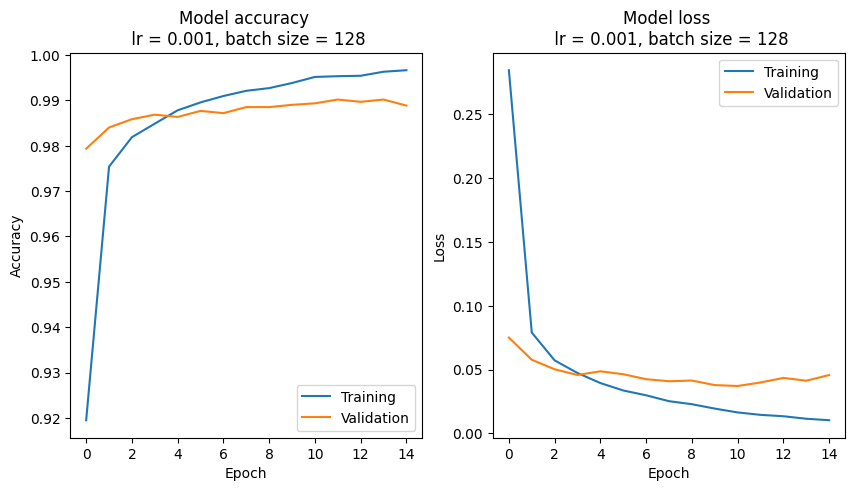

The model has a training accuracy of 99.66%
The model has a validation accuracy of 98.88%


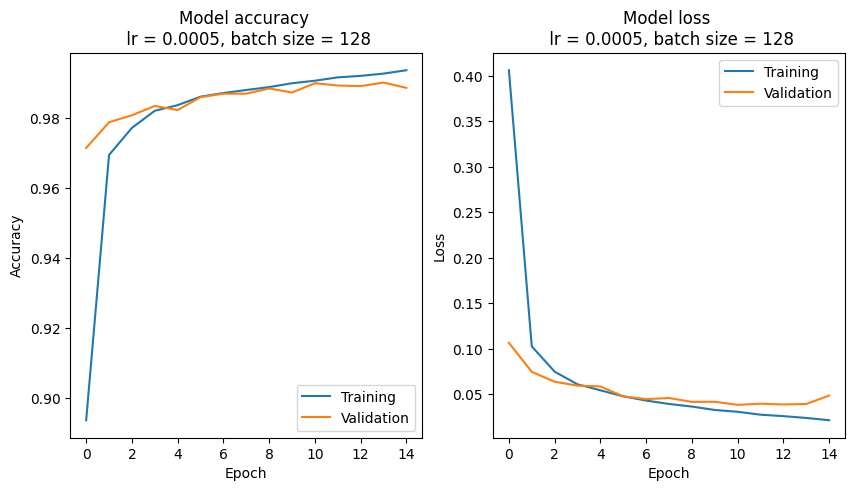

The model has a training accuracy of 99.35%
The model has a validation accuracy of 98.85%


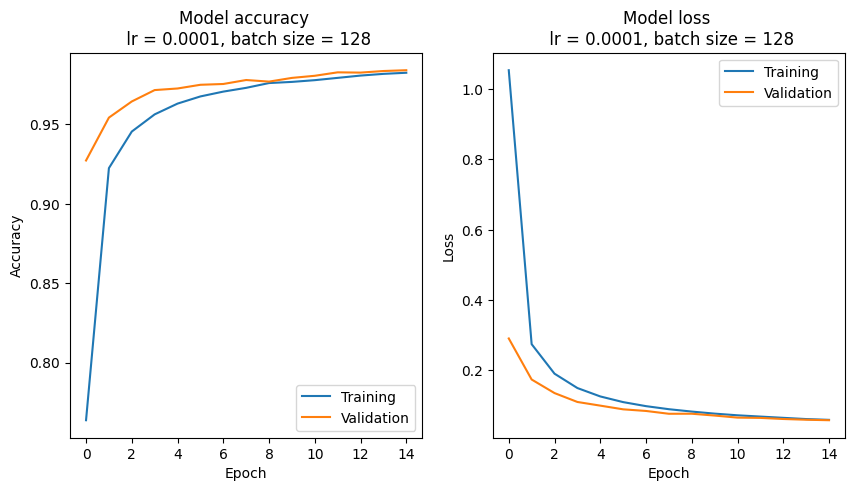

The model has a training accuracy of 98.24%
The model has a validation accuracy of 98.40%


In [ ]:
for i in range(len(lr)):
    learning_rate_eps = history_all[i]['learning_rate']
    batch_size_eps = history_all[i]['batch_size']

    plot_performance(history_all[i]['history'],learning_rate_eps,batch_size_eps)

## Batch size experiment



In [ ]:
history_all = []

batch_size = [32, 64, 128]
epochs = 5
lr = 0.0001

for i in range(len(batch_size)):
    # Reset the weights of the model to start training from the same initial weights
    model.set_weights(intial_weights)

    # Adjust the optimizer with the corresponding learning rate
    optimizer = keras.optimizers.Adam(learning_rate = lr)

    model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

    print(f"=== Model training with lr = {lr}, batch size = {batch_size[i]} ===")
    history = model.fit(x_train, y_train, batch_size=batch_size[i], epochs=epochs, validation_split=0.2)

    # Append a dictionary of the training parameters and training history
    history_all.append({
        'learning_rate': lr,
        'batch_size': batch_size[i],
        'history': history
    })

=== Model training with lr = 0.0001, batch size = 32 ===
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7375 - loss: 1.0269 - val_accuracy: 0.9587 - val_loss: 0.1559
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9527 - loss: 0.1691 - val_accuracy: 0.9733 - val_loss: 0.1043
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9655 - loss: 0.1172 - val_accuracy: 0.9747 - val_loss: 0.0868
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9709 - loss: 0.0949 - val_accuracy: 0.9780 - val_loss: 0.0735
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9758 - loss: 0.0803 - val_accuracy: 0.9813 - val_loss: 0.0676
=== Model training with lr = 0.0001, batch size = 64 ===
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6668 - loss: 1.3248 - val_accuracy: 0.9450 - val_loss: 0.2023
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9346 - loss: 0.2289 - val_accuracy: 0.9657 - val_

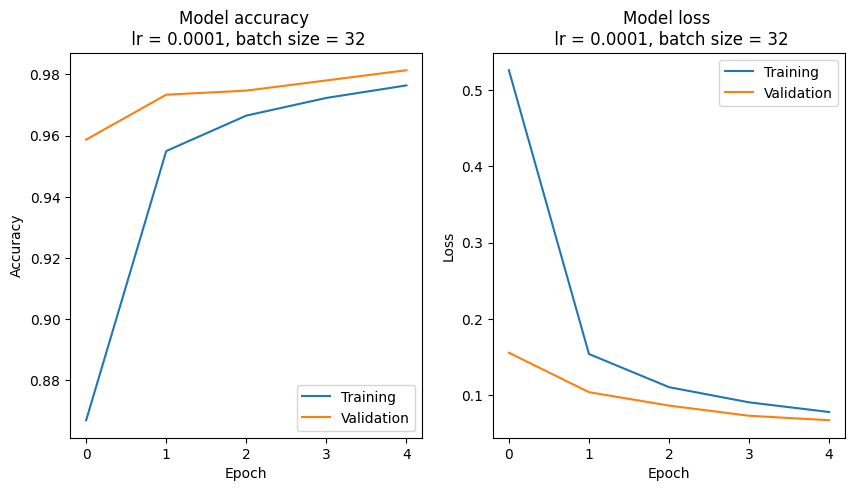

The model has a training accuracy of 97.64%
The model has a validation accuracy of 98.13%


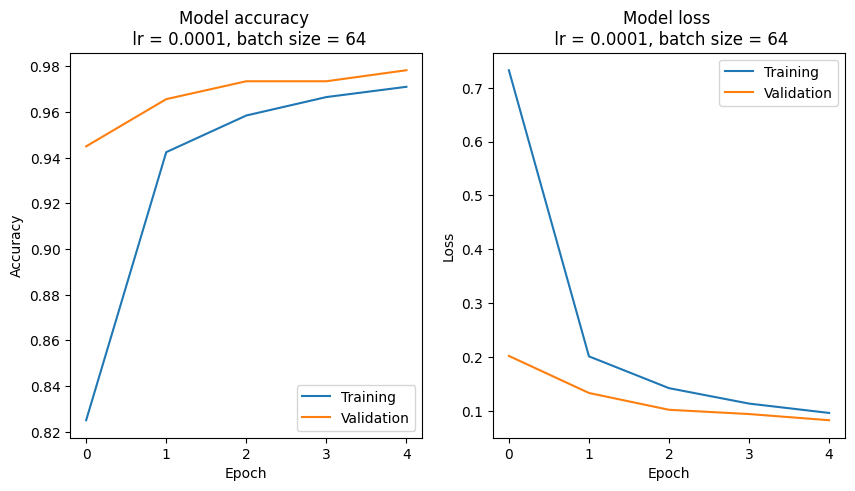

The model has a training accuracy of 97.11%
The model has a validation accuracy of 97.83%


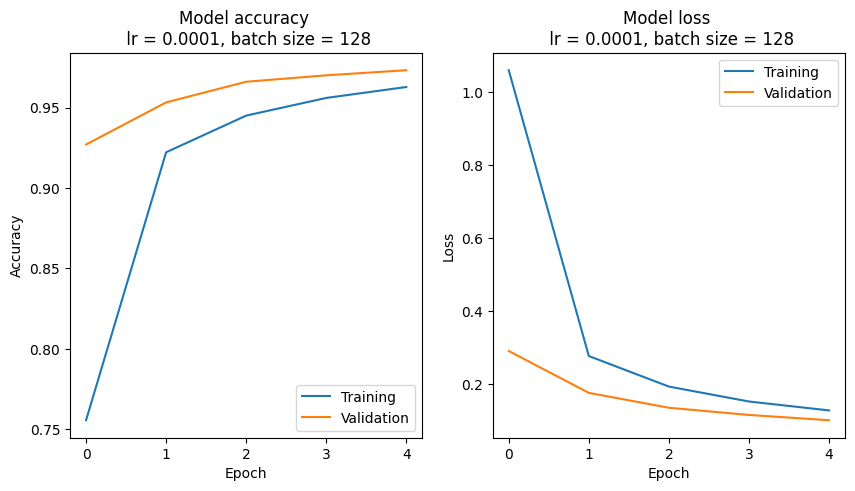

The model has a training accuracy of 96.27%
The model has a validation accuracy of 97.32%


In [ ]:
for i in range(len(batch_size)):
    learning_rate_eps = history_all[i]['learning_rate']
    batch_size_eps = history_all[i]['batch_size']

    plot_performance(history_all[i]['history'],learning_rate_eps,batch_size_eps)

## Model Architecture Experiment



In [ ]:
batch_size = 128
lr = 0.0001
epochs = 50

optimizer = keras.optimizers.Adam(
    learning_rate = lr
)

In [ ]:
model_2Conv = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(output_classes, activation="softmax"),
])

model_2Conv.summary()

model_2Conv.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

history_2Conv = model_2Conv.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

d:\Minh Nguyen\TME_6015\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        54,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,410 (212.54 KB)

 Trainable params: 54,410 (212.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6075 - loss: 1.6910 - val_accuracy: 0.8819 - val_loss: 0.5206
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8793 - loss: 0.4849 - val_accuracy: 0.9137 - val_loss: 0.3321
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9068 - loss: 0.3431 - val_accuracy: 0.9244 - val_loss: 0.2798
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9174 - loss: 0.2910 - val_accuracy: 0.9329 - val_loss: 0.2500
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9266 - loss: 0.2557 - val_accuracy: 0.9362 - val_loss: 0.2301
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9326 - loss: 0.2394 - val_accuracy: 0.9423 - val_loss: 0.2130
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9367 - loss: 0.2165 - val_accuracy: 0.9466 - val_loss: 0.1986
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9418 - loss: 0.2029 - val_accuracy: 0.

In [ ]:
model_3Conv = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(output_classes, activation="softmax"),
])

model_3Conv.summary()

model_3Conv.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

history_3Conv = model_3Conv.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

In [ ]:
model_4Conv = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(output_classes, activation="softmax"),
])

model_4Conv.summary()

model_4Conv.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

history_4Conv = model_4Conv.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Custom Test Set

## Import the Test Set


In this section, I will import my own handwritten digits as a custome dataset. The dataset has 25 instances of each digit, meaning 250 samples in total. The samples of each digit is contained within their respective folders with their corresponding name, which also acts as the label since the folder name is later extracted as the custom label. 

The path for the import is different on Google Colab and on a PC. For this assignment, I ran model training on my own PC so that path was chosen. Each of the image was resized to 28x28 pixels to match the input shape of the MNIST dataset

In [131]:
import os
import numpy as np
from PIL import Image
import cv2
from keras.utils import to_categorical

output_classes = 10

# Load custom images from Google Drive
custom_images_raw = []
custom_labels_raw = []

# Use the following when working on Google Colab
# base_folder_path = '/content/drive/MyDrive/TME6015/Assignment 1/Custom_Dataset'

# Use the following path when working on PC
base_folder_path = '\\Minh Nguyen\\TME_6015\\Assignment_1\\Custom Set'
for folder_name in os.listdir(base_folder_path):
    folder_path = os.path.join(base_folder_path, folder_name)
    print(folder_path)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith('.png') or filename.endswith('.PNG') or filename.endswith('.JPG'):
                img_path = os.path.join(folder_path, filename)
                img = Image.open(img_path).convert('L')  # Convert image to grayscale
                img = img.resize((28, 28))  # Resize image to match MNIST data

                # Thresholding
                threshold = 100
                img = img.point(lambda p: p > threshold and 255)

                img_array = np.array(img)

                # Convert to uint8 for OpenCV
                img_array = np.uint8(img_array)

                # Dilation to thicken brush strokes
                kernel = np.ones((2, 2), np.uint8)  # Create a 5x5 kernel for dilation
                img_dilated = cv2.erode(img_array, kernel, iterations=1)

                custom_images_raw.append(img_dilated)
                custom_labels_raw.append(int(folder_name))  # Use folder name as label

# Convert the list of custom images and labels to numpy arrays
custom_images_raw = np.array(custom_images_raw)
custom_labels_raw = np.array(custom_labels_raw)

# Preprocess the custom images
custom_images = (255-custom_images_raw) / -255.0

# One hot encode the labels
custom_labels = to_categorical(custom_labels_raw, num_classes=output_classes)

print(f"Dimension of the custom_images set: {custom_images.shape}\n"
      f"Dimension of the y_train set: {custom_labels.shape}")


\Minh Nguyen\TME_6015\Assignment_1\Custom Set\0
\Minh Nguyen\TME_6015\Assignment_1\Custom Set\1
\Minh Nguyen\TME_6015\Assignment_1\Custom Set\2
\Minh Nguyen\TME_6015\Assignment_1\Custom Set\3
\Minh Nguyen\TME_6015\Assignment_1\Custom Set\4
\Minh Nguyen\TME_6015\Assignment_1\Custom Set\5
\Minh Nguyen\TME_6015\Assignment_1\Custom Set\6
\Minh Nguyen\TME_6015\Assignment_1\Custom Set\7
\Minh Nguyen\TME_6015\Assignment_1\Custom Set\8
\Minh Nguyen\TME_6015\Assignment_1\Custom Set\9
Dimension of the custom_images set: (250, 28, 28)
Dimension of the y_train set: (250, 10)


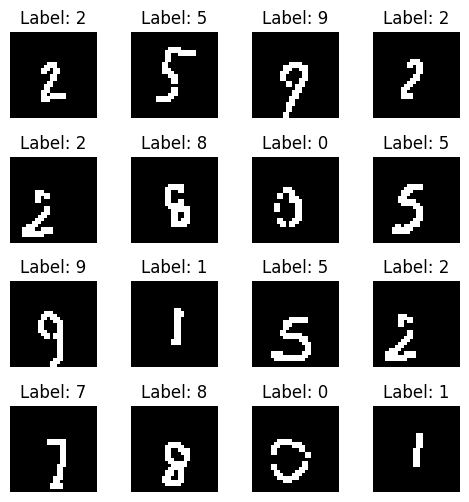

In [132]:
custom_images.shape

num_samples = 16; num_rows = 4; num_cols = 4
rand = random.randint(250,size = (num_samples))
x_samples = custom_images[rand,:,:]
y_samples = np.argmax(custom_labels[rand],axis=1)

fig, axes = plt.subplots(num_rows,num_cols,figsize=(5,5))

for i in range(num_rows):
  for j in range(num_cols):
    ax = axes[i,j]
    ax.imshow(x_samples[i*num_cols+j,:,:], cmap=matplotlib.cm.Greys)
    ax.axis("off")
    ax.set_title(f"Label: {y_samples[i*num_cols+j]}")

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust top to make room for title
plt.show()

## Evaluate the model performance

In [143]:
batch_size = 32
lr = 0.0001
epochs = 20

optimizer = keras.optimizers.Adam(
    learning_rate = lr
)

# Add the custom images and labels to the original MNIST dataset
# x_train = np.concatenate((x_train, custom_images), axis=0)
# y_train = np.concatenate((y_train, custom_labels), axis=0)

tf.keras.backend.clear_session(
    free_memory=True
)
model_2Conv = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(output_classes, activation="softmax"),
])

model_2Conv.summary()

model_2Conv.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

history_2Conv = model_2Conv.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,394 (220.29 KB)

 Trainable params: 56,394 (220.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6827 - loss: 1.2230 - val_accuracy: 0.9375 - val_loss: 0.2195
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9382 - loss: 0.2074 - val_accuracy: 0.9557 - val_loss: 0.1502
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9544 - loss: 0.1491 - val_accuracy: 0.9665 - val_loss: 0.1179
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9639 - loss: 0.1202 - val_accuracy: 0.9702 - val_loss: 0.1052
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9682 - loss: 0.1041 - val_accuracy: 0.9708 - val_loss: 0.0986
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9703 - loss: 0.0934 - val_accuracy: 0.9729 - val_loss: 0.0934
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9752 - loss: 0.0832 - val_accuracy: 0.9755 - val_loss: 0.0855
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9759 - loss: 0.0

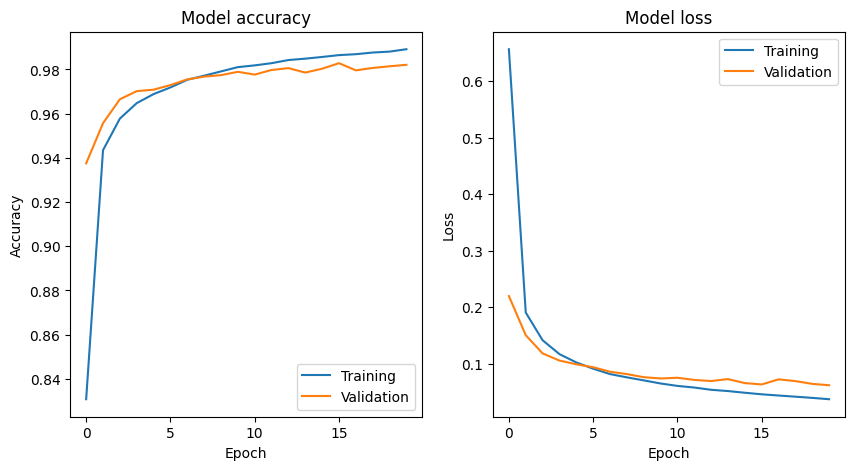

In [144]:
plot_performance(history_2Conv)

In [145]:
test_model = model_2Conv

custom_loss, custom_accuracy = test_model.evaluate(custom_images, custom_labels, verbose=1)
print(f"Custom Data - Loss: {custom_loss}, Accuracy: {custom_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1834 - loss: 2.4486
Custom Data - Loss: 2.242121934890747, Accuracy: 0.24400000274181366


In the following code block, I am using the trained model to make predictions on the custom dataset. Afterward, I will visualize the model prediction and compare it with the label imported from the custom set

In [146]:
predictions = test_model.predict(custom_images)
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[1 6 6 9 2 2 2 6 5 5 5 5 5 9 2 2 5 5 2 2 2 0 5 5 6 6 1 6 6 0 6 6 2 6 2 6 6
 6 6 0 9 2 0 6 6 6 0 6 6 1 2 2 7 2 7 2 2 7 7 7 2 7 9 7 2 7 5 5 2 5 7 7 2 9
 2 5 2 9 9 9 6 2 2 5 5 2 9 5 5 2 5 2 2 5 5 9 9 2 2 5 7 1 5 2 3 1 9 5 9 5 2
 1 1 0 1 6 5 6 6 1 0 5 0 9 5 9 9 9 5 5 5 5 9 5 3 5 5 5 5 5 5 9 5 5 5 5 5 5
 9 5 6 6 6 9 9 6 6 6 6 6 6 6 7 6 1 6 3 6 6 6 0 1 7 6 9 5 2 2 7 2 7 2 2 2 2
 6 2 2 2 1 2 2 7 2 6 6 2 2 2 6 0 9 5 9 7 9 9 6 6 9 6 9 2 9 9 6 9 0 5 6 2 6
 6 9 0 9 9 9 9 6 9 6 9 5 6 5 9 9 6 5 5 5 2 9 5 5 9 5 5 9]


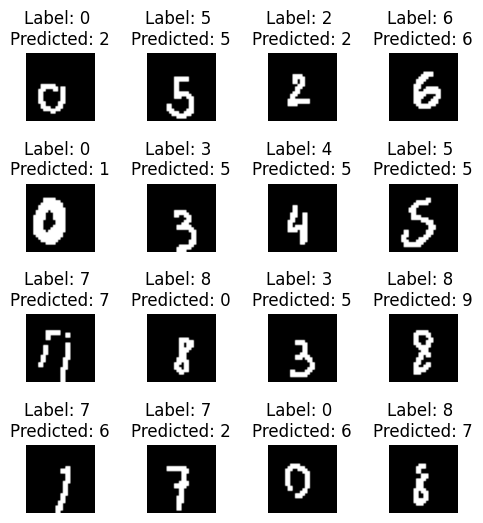

In [147]:
custom_images.shape

num_samples = 16; num_rows = 4; num_cols = 4
rand = random.randint(250,size = (num_samples))
x_samples = custom_images[rand,:,:]
y_samples = np.argmax(custom_labels[rand],axis=1)
y_predicted = np.argmax(predictions[rand],axis=1)
fig, axes = plt.subplots(num_rows,num_cols,figsize=(5,5))

for i in range(num_rows):
  for j in range(num_cols):
    ax = axes[i,j]
    ax.imshow(x_samples[i*num_cols+j,:,:], cmap=matplotlib.cm.Greys)
    ax.axis("off")
    ax.set_title(f"Label: {y_samples[i*num_cols+j]} \n"
                 f"Predicted: {y_predicted[i*num_cols+j]}")

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust top to make room for title
plt.show()